# Classification Problem on Urban Tree Dataset

## PreProcessing

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix, RocCurveDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

### Importing the Data set, Cleaning Data and Handling Missing Values

In [2]:
df = pd.read_csv('sgl-arbres-urbains-wgs84.csv')

In [3]:
df= df.drop(["ID_ARBRE", "commune", "controle", "insecte_collet", "insecte_tronc", "insecte_houppier","circonference (en cm)", "observation_collet", "observation_tronc", "observation_houppier"], axis=1 )
#Handling Missing Values
mode_cote_voirie=df.cote_voirie.mode()[0]
mode_espece_arbre=df.espece_arbre.mode()[0]
mode_situation=df.situation.mode()[0]
mode_plaie_collet=df.plaie_collet.mode()[0]
mode_champignon_tronc=df.champignon_tronc.mode()[0]
mode_fissure_tronc=df.fissure_tronc.mode()[0]
mode_rejet_tronc=df.rejet_tronc.mode()[0]
mode_plaie_tronc=df.plaie_tronc.mode()[0]
mode_champignon_houppier=df.champignon_houppier.mode()[0]
mode_fissure_houppier=df.fissure_houppier.mode()[0]
mode_ecorce_incluse_houppier=df.ecorce_incluse_houppier.mode()[0]
mode_bois_mort_houppier=df.bois_mort_houppier.mode()[0]
mode_plaie_houppier=df.plaie_houppier.mode()[0]
mode_contrainte=df.contrainte.mode()[0]
mode_classification_diagnostic=df.classification_diagnostic.mode()[0]
median_esperance_maintien=df.esperance_maintien.median()

df=df.fillna({"cote_voirie": mode_cote_voirie, "espece_arbre": mode_espece_arbre, "situation": mode_situation,
            "plaie_collet": mode_plaie_collet, "champignon_tronc": mode_champignon_tronc,
            "fissure_tronc": mode_fissure_tronc, "rejet_tronc": mode_rejet_tronc, "plaie_tronc": mode_plaie_tronc, 
              "champignon_houppier": mode_champignon_houppier, "fissure_houppier":mode_fissure_houppier, "ecorce_incluse_houppier": mode_ecorce_incluse_houppier,
            "bois_mort_houppier": mode_bois_mort_houppier, "plaie_houppier": mode_plaie_houppier, "contrainte": mode_contrainte,
            "classification_diagnostic": mode_classification_diagnostic, "esperance_maintien": median_esperance_maintien})

In [4]:
df.head()

,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,situation,type_sol,surf_permeable,date_plantation,...,canisse_arbre,plaie_tronc,champignon_houppier,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,esperance_maintien,contrainte,classification_diagnostic
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,7,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLNC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,8,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,9,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLCF,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,1,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,2,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2


In [5]:
#define function to swap columns so that all numerical data will be in the end columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    a, b = col_list.index(col1), col_list.index(col2)
    col_list[b], col_list[a] = col_list[a], col_list[b]
    df = df[col_list]
    return df

#swaping columns
df = swap_columns(df, 'matricule_arbre', 'contrainte')
df = swap_columns(df, 'surf_permeable', 'plaie_houppier')
df = swap_columns(df, 'date_plantation', 'bois_mort_houppier')
df = swap_columns(df, 'hauteur', 'ecorce_incluse_houppier')
df = swap_columns(df, 'diametre', 'fissure_houppier')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quartier                   709 non-null    object 
 1   site                       709 non-null    object 
 2   cote_voirie                709 non-null    object 
 3   contrainte                 709 non-null    object 
 4   genre_arbre                709 non-null    object 
 5   espece_arbre               709 non-null    object 
 6   situation                  709 non-null    object 
 7   type_sol                   709 non-null    object 
 8   plaie_houppier             709 non-null    object 
 9   bois_mort_houppier         709 non-null    object 
 10  classe_age                 709 non-null    object 
 11  ecorce_incluse_houppier    709 non-null    object 
 12  classe_hauteur             709 non-null    object 
 13  fissure_houppier           709 non-null    object 

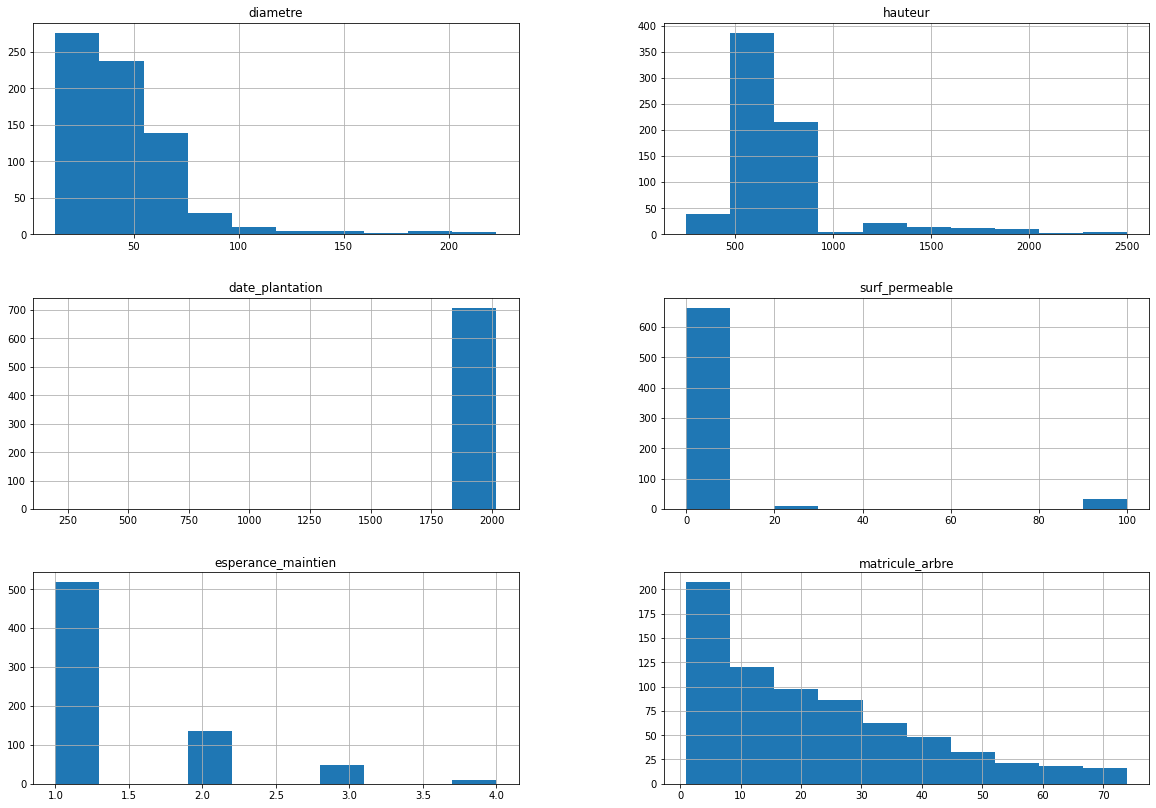

In [6]:
_ = df.hist(figsize=(20, 14))

In [7]:
cor_matrix = df.corr()
cor_matrix

,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
diametre,1.000000,0.759239,-0.155416,0.408231,0.329892,-0.109965
hauteur,0.759239,1.000000,-0.090306,0.604309,0.225723,-0.164903
date_plantation,-0.155416,-0.090306,1.000000,-0.071507,-0.033480,-0.007850
surf_permeable,0.408231,0.604309,-0.071507,1.000000,0.224826,-0.217633
esperance_maintien,0.329892,0.225723,-0.033480,0.224826,1.000000,-0.023423
matricule_arbre,-0.109965,-0.164903,-0.007850,-0.217633,-0.023423,1.000000


In [8]:
df.nunique()

quartier                      6
site                         30
cote_voirie                   2
contrainte                    2
genre_arbre                  26
espece_arbre                 37
situation                     4
type_sol                      9
plaie_houppier                5
bois_mort_houppier            3
classe_age                    4
ecorce_incluse_houppier       2
classe_hauteur                5
fissure_houppier              3
classe_circonference          7
port_arbre                    5
vigueur_pousse                4
champignon_collet             2
plaie_collet                  7
champignon_tronc              2
fissure_tronc                 3
rejet_tronc                   2
tuteurage_arbre               4
canisse_arbre                 2
plaie_tronc                   6
champignon_houppier           2
diametre                     42
hauteur                      17
date_plantation              13
surf_permeable                9
esperance_maintien            4
matricul

In [9]:
df['classification_diagnostic'].value_counts()

C2    408
C1    237
C3     43
C4     11
C5     10
Name: classification_diagnostic, dtype: int64

In [10]:
target_name = "classification_diagnostic"
target = df[target_name]
data = df.drop(columns=[target_name])

### Ordinal Encoding

In [11]:
from sklearn.compose import make_column_selector as selector
#Separating Numerical and Categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

categorical_columns = categorical_columns_selector(data)
data_categorical = data[categorical_columns]
data_categorical.head()

,quartier,site,cote_voirie,contrainte,genre_arbre,espece_arbre,situation,type_sol,plaie_houppier,bois_mort_houppier,...,vigueur_pousse,champignon_collet,plaie_collet,champignon_tronc,fissure_tronc,rejet_tronc,tuteurage_arbre,canisse_arbre,plaie_tronc,champignon_houppier
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Betula,Alba,Groupe,P,HPLC,HBMI,...,P,Non,RCPLNS,Non,TPF,Non,Non,Non,TPLNC,Non
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Betula,Alba,Groupe,P,HPLC,HBMI,...,P,Non,RCPPL,Non,TPF,Non,Non,Non,TPLC,Non
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Betula,Alba,Groupe,P,HPLC,HBMI,...,P,Non,RCPPL,Non,TPF,Non,Non,Non,TPLCF,Non
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,HPLS,HBMI,...,P,Non,RCPPL,Non,TPF,Non,Non,Non,TPLS,Non
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,HPLS,HBMI,...,P,Non,RCPPL,Non,TPF,Non,Non,Non,TPLS,Non


In [12]:
print(f"The dataset is composed of {data_categorical.shape[1]} Categorical features")

The dataset is composed of 26 Categorical features


In [13]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

categorical_encoder = OrdinalEncoder()
data_encoded = categorical_encoder.fit_transform(data_categorical)
data_encoded.shape

(709, 26)

In [14]:
data_encoded[:5]

array([[1., 5., 0., 0., 4., 0., 2., 6., 0., 0., 0., 0., 1., 2., 1., 4.,
        2., 0., 4., 0., 2., 0., 0., 0., 2., 0.],
       [1., 5., 0., 0., 4., 0., 2., 6., 0., 0., 0., 0., 1., 2., 1., 4.,
        2., 0., 6., 0., 2., 0., 0., 0., 0., 0.],
       [1., 5., 0., 0., 4., 0., 2., 6., 0., 0., 0., 0., 1., 2., 1., 4.,
        2., 0., 6., 0., 2., 0., 0., 0., 1., 0.],
       [1., 5., 0., 0., 5., 8., 1., 2., 2., 0., 0., 0., 3., 2., 1., 1.,
        2., 0., 6., 0., 2., 0., 0., 0., 3., 0.],
       [1., 5., 0., 0., 5., 8., 1., 2., 2., 0., 0., 0., 3., 2., 5., 1.,
        2., 0., 6., 0., 2., 0., 0., 0., 3., 0.]])

In [15]:
print(
    f"The dataset encoded contains {data_encoded.shape[1]} features")

The dataset encoded contains 26 features


In [16]:
len(categorical_columns)

26

In [17]:
categorical_columns

['quartier',
 'site',
 'cote_voirie',
 'contrainte',
 'genre_arbre',
 'espece_arbre',
 'situation',
 'type_sol',
 'plaie_houppier',
 'bois_mort_houppier',
 'classe_age',
 'ecorce_incluse_houppier',
 'classe_hauteur',
 'fissure_houppier',
 'classe_circonference',
 'port_arbre',
 'vigueur_pousse',
 'champignon_collet',
 'plaie_collet',
 'champignon_tronc',
 'fissure_tronc',
 'rejet_tronc',
 'tuteurage_arbre',
 'canisse_arbre',
 'plaie_tronc',
 'champignon_houppier']

In [18]:
#Adding Numpy array into pandas data frame (Numerical columns)
data_cat_encoded_to_num = pd.DataFrame(data_encoded, columns=['quartier',
 'site',
 'cote_voirie',
 'contrainte',
 'genre_arbre',
 'espece_arbre',
 'situation',
 'type_sol',
 'plaie_houppier',
 'bois_mort_houppier',
 'classe_age',
 'ecorce_incluse_houppier',
 'classe_hauteur',
 'fissure_houppier',
 'classe_circonference',
 'port_arbre',
 'vigueur_pousse',
 'champignon_collet',
 'plaie_collet',
 'champignon_tronc',
 'fissure_tronc',
 'rejet_tronc',
 'tuteurage_arbre',
 'canisse_arbre',
 'plaie_tronc',
 'champignon_houppier'])

In [19]:
data_cat_encoded_to_num.head()

,quartier,site,cote_voirie,contrainte,genre_arbre,espece_arbre,situation,type_sol,plaie_houppier,bois_mort_houppier,...,vigueur_pousse,champignon_collet,plaie_collet,champignon_tronc,fissure_tronc,rejet_tronc,tuteurage_arbre,canisse_arbre,plaie_tronc,champignon_houppier
0,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,2.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
1,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,2.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,2.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
3,1.0,5.0,0.0,0.0,5.0,8.0,1.0,2.0,2.0,0.0,...,2.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0
4,1.0,5.0,0.0,0.0,5.0,8.0,1.0,2.0,2.0,0.0,...,2.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0


In [20]:
from sklearn.compose import make_column_selector as selector
#Separating Numerical and Categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [21]:
data_numerical = data[numerical_columns]
data_numerical_all_features= pd.concat([data_cat_encoded_to_num, data_numerical], axis=1)

In [22]:
data_numerical_all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quartier                 709 non-null    float64
 1   site                     709 non-null    float64
 2   cote_voirie              709 non-null    float64
 3   contrainte               709 non-null    float64
 4   genre_arbre              709 non-null    float64
 5   espece_arbre             709 non-null    float64
 6   situation                709 non-null    float64
 7   type_sol                 709 non-null    float64
 8   plaie_houppier           709 non-null    float64
 9   bois_mort_houppier       709 non-null    float64
 10  classe_age               709 non-null    float64
 11  ecorce_incluse_houppier  709 non-null    float64
 12  classe_hauteur           709 non-null    float64
 13  fissure_houppier         709 non-null    float64
 14  classe_circonference     7

In [23]:
data_numerical_all_features.head()

,quartier,site,cote_voirie,contrainte,genre_arbre,espece_arbre,situation,type_sol,plaie_houppier,bois_mort_houppier,...,tuteurage_arbre,canisse_arbre,plaie_tronc,champignon_houppier,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
0,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,0.0,0.0,2.0,0.0,63.661977,1000,2000,5.0,1.0,7
1,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,60.478878,1000,2000,5.0,1.0,8
2,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,54.112681,1000,2000,5.0,1.0,9
3,1.0,5.0,0.0,0.0,5.0,8.0,1.0,2.0,2.0,0.0,...,0.0,0.0,3.0,0.0,63.661977,1600,1980,100.0,1.0,1
4,1.0,5.0,0.0,0.0,5.0,8.0,1.0,2.0,2.0,0.0,...,0.0,0.0,3.0,0.0,190.985932,1600,1980,100.0,1.0,2


In [24]:
X = data_numerical_all_features.iloc[:].values
y = target.iloc[:].values

In [25]:
print(X.shape)
print(y.shape)

(709, 32)
(709,)


In [26]:
X

array([[ 1.,  5.,  0., ...,  5.,  1.,  7.],
       [ 1.,  5.,  0., ...,  5.,  1.,  8.],
       [ 1.,  5.,  0., ...,  5.,  1.,  9.],
       ...,
       [ 0., 11.,  0., ...,  1.,  1.,  6.],
       [ 0., 11.,  0., ...,  1.,  2.,  7.],
       [ 0., 11.,  0., ...,  1.,  1.,  8.]])

In [27]:
le = LabelEncoder()
y = le.fit_transform(y)

In [28]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 0, 3, 1, 2, 1, 2, 3, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [29]:
print(X.shape)
print(y.shape)

(709, 32)
(709,)


In [30]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 237]
 [  1 408]
 [  2  43]
 [  3  11]
 [  4  10]]


In [31]:
type(X)

numpy.ndarray

In [32]:
type(y)

numpy.ndarray

## Splitting the dataset into the Training set and Test set

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

## Decision Tree Model without pruning

## Training the Decision Tree Classification model on the Training set

In [34]:
%%time
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion='entropy', random_state=0)
DT.fit(X_train, y_train)

Wall time: 19 ms


DecisionTreeClassifier(criterion='entropy', random_state=0)

## Predicting the Test set results

In [35]:
DT.tree_.node_count

191

In [36]:
DT.tree_.max_depth

13

In [37]:
y_pred = DT.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

## Making the Confusion Matrix

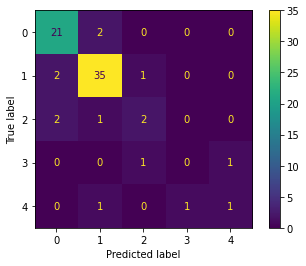

model accuracy: 0.831


In [38]:
cm = confusion_matrix(y_test, y_pred)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [39]:
%%time
from sklearn.model_selection import cross_val_score
DT = DecisionTreeClassifier(criterion = 'entropy')
accuracies = cross_val_score(estimator = DT, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.8359375  0.796875   0.890625   0.82677165 0.8503937 ]
Mean Accuracy: 84.01 %
Standard Deviation: 3.07 %
Wall time: 17 ms


## Decision Tree Model with pruning

## Training the Decision Tree Classification model on the Training set

In [40]:
%%time
from sklearn.tree import DecisionTreeClassifier
DTWP = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=8, max_leaf_nodes= 50, ccp_alpha=0.00625)
DTWP.fit(X_train, y_train)

Wall time: 3 ms


DecisionTreeClassifier(ccp_alpha=0.00625, criterion='entropy', max_depth=8,
                       max_leaf_nodes=50, random_state=0)

## Predicting the Test set results

In [41]:
DTWP.tree_.node_count

77

In [42]:
DTWP.tree_.max_depth

8

In [43]:
y_pred = DTWP.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

## Making the Confusion Matrix

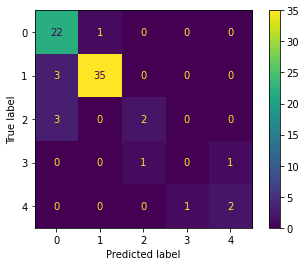

model accuracy: 0.859


In [44]:
cm = confusion_matrix(y_test, y_pred)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [45]:
%%time
from sklearn.model_selection import cross_val_score
DTWP = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=8, max_leaf_nodes= 50, ccp_alpha=0.00625)
accuracies = cross_val_score(estimator = DTWP, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.8671875 0.796875  0.8828125 0.8503937 0.8503937]
Mean Accuracy: 84.95 %
Standard Deviation: 2.90 %
Wall time: 16.1 ms


## Random Forest Model

In [46]:
%%time
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
RF.fit(X_train, y_train)

Wall time: 135 ms


RandomForestClassifier(criterion='entropy', random_state=0)

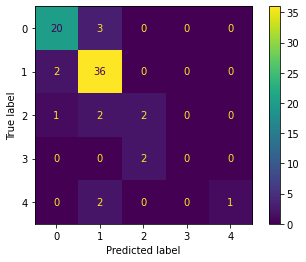

model accuracy: 0.831


In [47]:
y_pred = RF.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [48]:
%%time
from sklearn.model_selection import cross_val_score
RF = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
accuracies = cross_val_score(estimator = RF, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.8515625  0.8203125  0.84375    0.85826772 0.85826772]
Accuracy: 84.64 %
Standard Deviation: 1.41 %
Wall time: 562 ms


## Bagging Model

In [49]:
%%time
from sklearn.ensemble import BaggingClassifier
BGG = BaggingClassifier(n_estimators = 100, random_state = 0)
BGG.fit(X_train, y_train)

Wall time: 213 ms


BaggingClassifier(n_estimators=100, random_state=0)

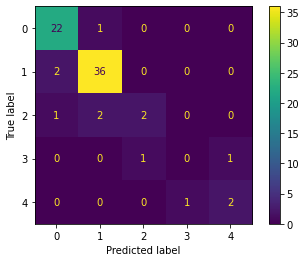

model accuracy: 0.873


In [50]:
y_pred = BGG.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Cross Validation 

In [51]:
%%time
from sklearn.model_selection import cross_val_score
BGG = BaggingClassifier(n_estimators = 100, random_state = 0)
accuracies = cross_val_score(estimator = BGG, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.84375    0.8359375  0.859375   0.86614173 0.84251969]
Accuracy: 84.95 %
Standard Deviation: 1.13 %
Wall time: 952 ms


## Adaptive Boosting

In [52]:
%%time
from sklearn.ensemble import AdaBoostClassifier
base_estimator= DecisionTreeClassifier(criterion = 'entropy',max_depth= 4, max_leaf_nodes= 11, random_state = 0)
AB = AdaBoostClassifier(base_estimator= base_estimator, n_estimators=200, learning_rate=0.4, algorithm='SAMME', random_state= 0)
AB.fit(X_train, y_train)

Wall time: 357 ms


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=4,
                                                         max_leaf_nodes=11,
                                                         random_state=0),
                   learning_rate=0.4, n_estimators=200, random_state=0)

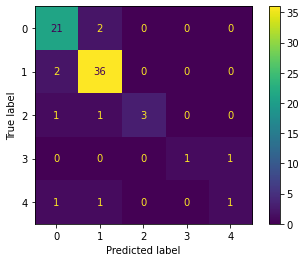

model accuracy: 0.873


In [53]:
y_pred = AB.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

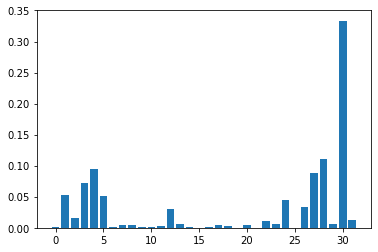

In [54]:
# plot
plt.bar(range(len(AB.feature_importances_)), AB.feature_importances_)
plt.show()

## Cross Validation 

In [55]:
%%time
from sklearn.model_selection import cross_val_score
AB = AB
accuracies = cross_val_score(estimator = AB, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.8515625  0.84375    0.859375   0.87401575 0.86614173]
Accuracy: 85.90 %
Standard Deviation: 1.06 %
Wall time: 1.62 s


## Gradient Boosting

In [56]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators=350, learning_rate=0.01, max_depth=6, max_leaf_nodes=16, subsample= 0.7, random_state= 0)
GB.fit(X_train, y_train)

Wall time: 2.45 s


GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_leaf_nodes=16,
                           n_estimators=350, random_state=0, subsample=0.7)

In [57]:
print(GB.feature_importances_)

[0.02495282 0.05302125 0.03442903 0.01018163 0.03508668 0.03310694
 0.00742219 0.02702099 0.0203945  0.00565021 0.00357471 0.01429824
 0.00789209 0.00632973 0.00408379 0.00929877 0.01260661 0.00698752
 0.06619315 0.00529614 0.00826294 0.00386462 0.00392613 0.20677318
 0.05356174 0.00169613 0.04490544 0.01557861 0.08793544 0.04151985
 0.0582483  0.08590063]


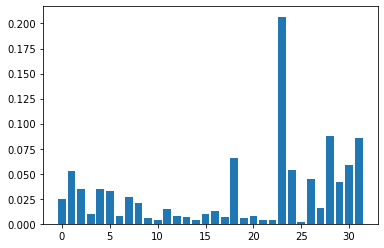

In [58]:
# plot
plt.bar(range(len(GB.feature_importances_)), GB.feature_importances_)
plt.show()

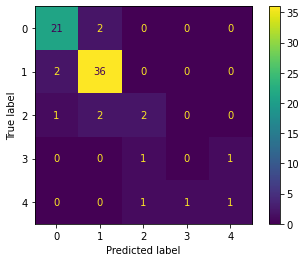

model accuracy: 0.845


In [59]:
y_pred = GB.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print("model accuracy: %.3f" % accuracy_score(y_test, y_pred))

## Applying K-Fold Cross Validation to Gradient Boosting

In [60]:
%%time
from sklearn.model_selection import cross_val_score
GB = GB
accuracies = cross_val_score(estimator = GB, X=X_train, y=y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

[0.859375   0.8515625  0.875      0.86614173 0.86614173]
Accuracy: 86.36 %
Standard Deviation: 0.78 %
Wall time: 10.8 s


DT: 0.838533 (0.029214)
DTWP: 0.849532 (0.028961)
RF: 0.846432 (0.014113)
BGG: 0.849545 (0.011315)
AB: 0.858969 (0.010625)
GB: 0.863644 (0.007818)


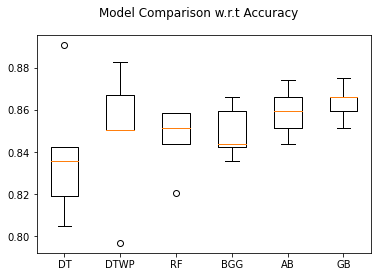

In [62]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
# load dataset
# prepare configuration for cross validation test harness
# prepare models
models = []
#models.append(('LR',LogisticRegression(random_state = 0, max_iter=1000)))
models.append(('DT',DT))
models.append(('DTWP',DTWP))
models.append(('RF',RF))
models.append(('BGG',BGG))
models.append(('AB',AB)) 
models.append(('GB',GB))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Model Comparison w.r.t Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()